# Summary:
- 1) Evaluated distribution of null values, and dropped rows with more than 6 missing values (excluding missing values in the target feature)

- 2) Looked at the 'city' column in greater detail, and binned into four (not entirely equal-sized) groups, based on the proportion of candidates from each city.

- 3) Plotted figures of numerical and categorical columns, and explored the distribution of the target feature across these.

- 4) Saved resulting dataframes with the changes made in steps 1) and 2)

In [1]:
#conda install missingno

In [2]:
import pandas as pd
import numpy as np
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_null = pd.read_csv('../data/df_clean_nulls.csv', index_col=0)
df_nonull = pd.read_csv('../data/df_clean_nonulls.csv', index_col=0)
df_null.shape, df_nonull.shape

((21287, 14), (21287, 14))

# I. Distribution of Null Values

In [4]:
# Number of NAs in each column

perc_na = round(df_null.isna().sum() * 100 / len(df_null), 2)

df_na = pd.DataFrame({'Total NA':df_null.isna().sum(), 'DType':df_null.dtypes, '% NA':perc_na})
df_na

,Total NA,DType,% NA
enrollee_id,0,int64,0.00
city,0,object,0.00
city_development_index,0,float64,0.00
gender,5016,object,23.56
relevent_experience,0,int64,0.00
enrolled_university,417,object,1.96
education_level,512,object,2.41
major,3125,object,14.68
company_size,6560,object,30.82
company_type,6774,object,31.82


Company size and type seem to have the most missing values, closely followed by gender.

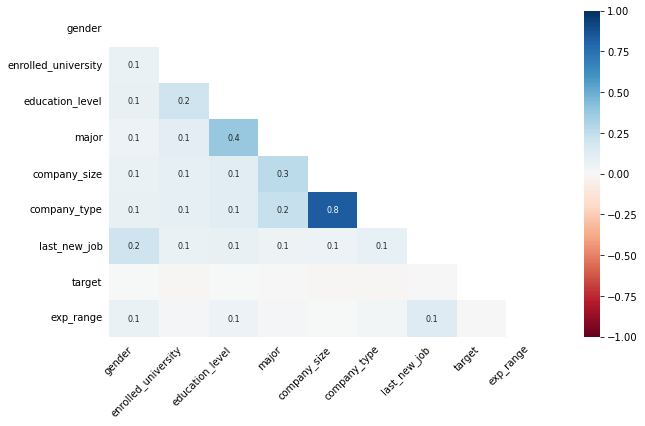

In [5]:
msno.heatmap(df_null, figsize=(10,6), fontsize=10);

If company size is filled in, company type most likely is too.

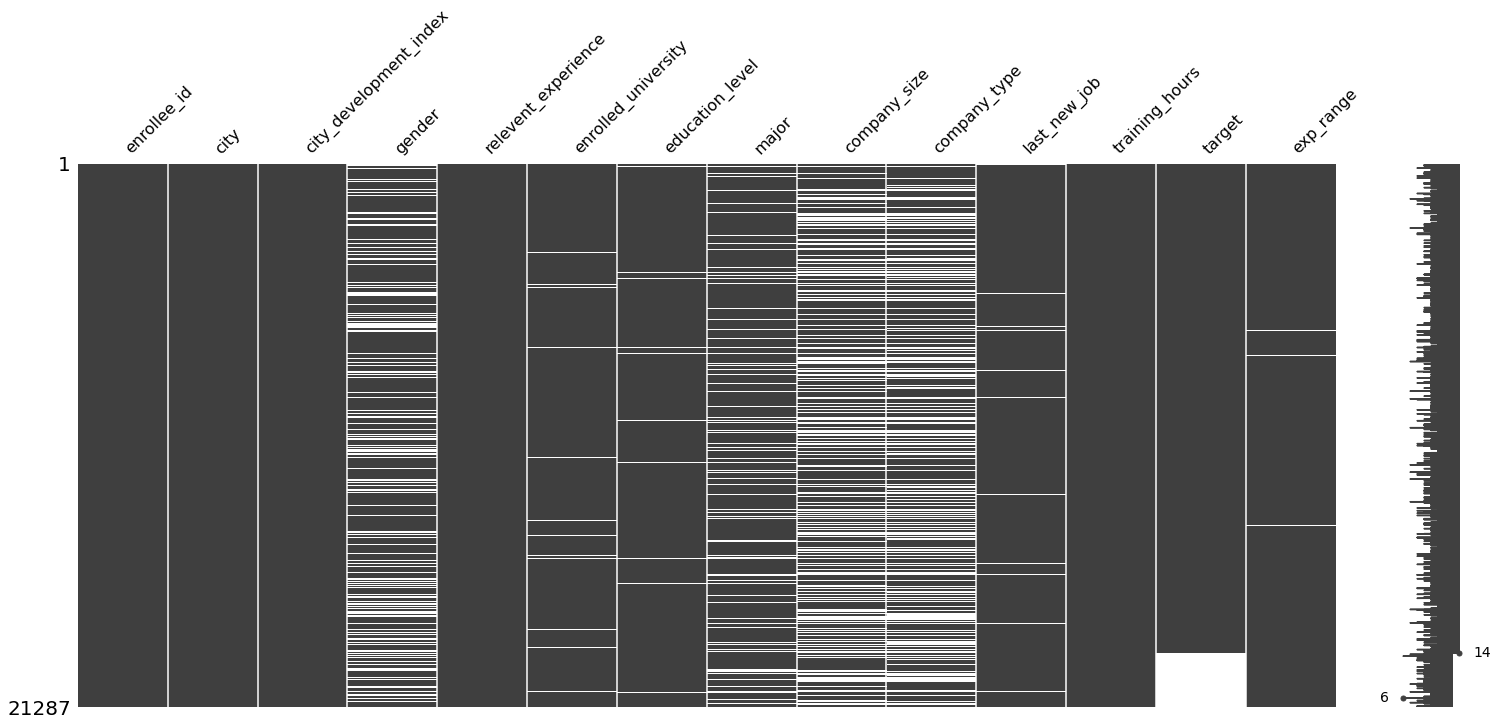

In [6]:
msno.matrix(df_null);

In [7]:
# Number of missing values per row, value counts (excluding target column)

row_nulls = df_null.drop(columns='target').apply(lambda x: x.isna().sum(), axis=1)
row_nulls.value_counts(ascending=False)

0    9974
1    4152
2    4030
3    2168
4     688
5     195
6      66
7      14
dtype: int64

14 rows have 7 missing values, and 66 have 6 missing values. It might be useful to drop these.

In [8]:
mask = df_null.apply(lambda x: x.isna().sum(), axis=1)>=5
sparse_rows = row_nulls[mask].index.tolist()
sparse_rows = [i for i in sparse_rows if i < 19158]

These rows will be dropped from both dfs, exclusing those that appear in the test dataset (rows past 19158)

In [9]:
len(sparse_rows)

250

In [10]:
df_null.drop(index=sparse_rows, inplace=True)
df_nonull.drop(index=sparse_rows, inplace=True)

In [11]:
df_null.shape, df_nonull.shape

((21037, 14), (21037, 14))

In [12]:
# Number of NAs in each column

perc_na = round(df_null.isna().sum() * 100 / len(df_null), 2)

df_na = pd.DataFrame({'Total NA':df_null.isna().sum(), 'DType':df_null.dtypes, '% NA':perc_na})
df_na

,Total NA,DType,% NA
enrollee_id,0,int64,0.00
city,0,object,0.00
city_development_index,0,float64,0.00
gender,4808,object,22.85
relevent_experience,0,int64,0.00
enrolled_university,302,object,1.44
education_level,336,object,1.60
major,2884,object,13.71
company_size,6317,object,30.03
company_type,6528,object,31.03


This didn't make much of a dent in terms of percentage of missing values

# II. Explore 'City' Column

In [13]:
# City distribution

city_df = pd.DataFrame(
    {'Total':df_nonull['city'].value_counts(),
     '% of Total':round(df_nonull['city'].value_counts() / df_nonull['city'].notna().sum() * 100, 2),
     'City Index':df_nonull.groupby(by='city').mean()['city_development_index']}
)

city_df.sort_values('Total', ascending=False).head(20)

,Total,% of Total,City Index
city_103,4786,22.75,0.920
city_21,2977,14.15,0.624
city_16,1687,8.02,0.910
city_114,1478,7.03,0.926
city_160,949,4.51,0.920
city_136,636,3.02,0.897
city_67,470,2.23,0.855
city_75,333,1.58,0.939
city_102,332,1.58,0.804
city_104,324,1.54,0.924


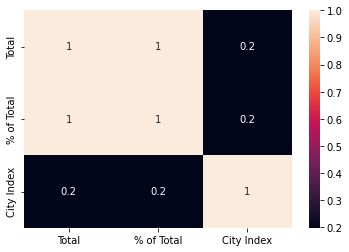

In [14]:
sns.heatmap(city_df.corr(), annot=True);

There seems to be a slight correlation between city's frequency in our df and its development index

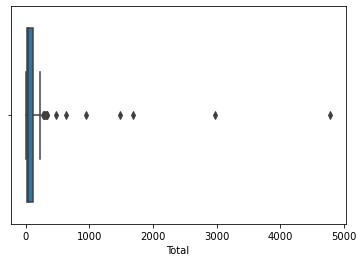

In [15]:
# How are applicants distributed along cities?

sns.boxplot(x='Total', data=city_df);

In [16]:
city_df.describe()

,Total,% of Total,City Index
count,123.000000,123.000000,123.000000
mean,171.032520,0.812846,0.753992
std,543.585832,2.583973,0.119872
min,1.000000,0.000000,0.448000
25%,14.000000,0.070000,0.698000
50%,30.000000,0.140000,0.754000
75%,113.500000,0.540000,0.851500
max,4786.000000,22.750000,0.949000


There are 123 cities total. While city_103 accounts for nearly a quarter of applicants, most cities fall in the lower range.

Lacking information on city names and location, it's difficult to determine why candidates are distributed along them in the way that they are. City_103 might account for nearly a quarter of all applicants because it is a large city population-wise, or because it's the city in which the company that collected this data is located.

In [17]:
# Main city with ~22% of total applicants

bin_1 = city_df.loc[city_df['% of Total']>=20]
cities_1 = bin_1.index.tolist()
bin_1[['Total', '% of Total']].sum()

Total         4786.00
% of Total      22.75
dtype: float64

In [18]:
# Secondary cities with 5-10% of total applicants

bin_2 = city_df.loc[(city_df['% of Total']>=5) & (city_df['% of Total']<20)]
cities_2 = bin_2.index.tolist()
bin_2[['Total', '% of Total']].sum()

Total         6142.0
% of Total      29.2
dtype: float64

In [19]:
# Percentage of cities with 1-5% of total applicants

bin_3 = city_df.loc[(city_df['% of Total']>=1) & (city_df['% of Total']<5)]
cities_3 = bin_3.index.tolist()
bin_3[['Total', '% of Total']].sum()

Total         4850.00
% of Total      23.05
dtype: float64

In [20]:
# Smallest cities with less than 1% of total applicants

bin_4 = city_df.loc[city_df['% of Total']<1]
cities_4 = bin_4.index.tolist()
bin_4[['Total', '% of Total']].sum()

Total         5259.00
% of Total      24.98
dtype: float64

Some possible ideas on how to bin city. This can probably be encoded as an ordinal feature, since there seem to be "tiers" of city frequency.

In [21]:
def city_group(city):
    """Map to bin years of experience"""
    if city in cities_1:
        return(0)
    elif city in cities_2:
        return(1)
    elif city in cities_3:
        return(2)
    elif city in cities_4:
        return(3)
    else:
        return(np.nan)

In [22]:
df_nonull['city_group'] = df_nonull['city'].apply(city_group)
df_null['city_group'] = df_null['city'].apply(city_group)
df_nonull[['city', 'city_group']].head(10)

,city,city_group
0,city_103,0
1,city_40,3
2,city_21,1
3,city_115,3
4,city_162,3
5,city_176,3
6,city_160,2
7,city_46,3
8,city_103,0
9,city_103,0


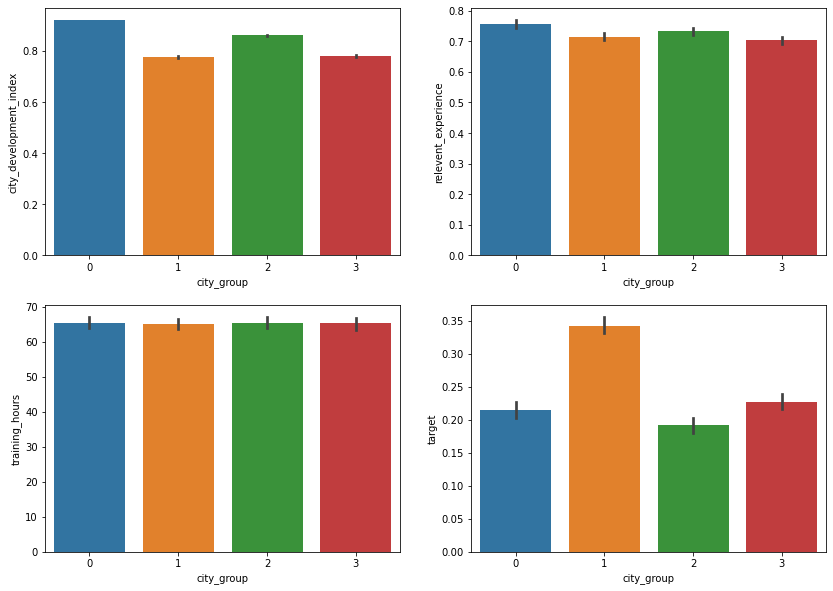

In [23]:
# City development index across city bins

fig, ax = plt.subplots(2,2, figsize=(14,10))
sns.barplot(x='city_group', y='city_development_index', data=df_nonull, ax=ax[0,0]);
sns.barplot(x='city_group', y='relevent_experience', data=df_nonull, ax=ax[0,1]);
sns.barplot(x='city_group', y='training_hours', data=df_nonull, ax=ax[1,0]);
sns.barplot(x='city_group', y='target', data=df_nonull, ax=ax[1,1]);

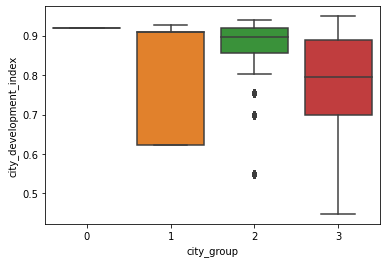

In [24]:
sns.boxplot(x='city_group', y='city_development_index', data=df_nonull);

# III. Relationship Between Variables

In [25]:
df_nonull.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major,company_size,company_type,last_new_job,training_hours,exp_range,target,city_group
0,8949,city_103,0.920,Male,1,no_enrollment,Graduate,STEM,MISSING,MISSING,1,36,>20,1.0,0
1,29725,city_40,0.776,Male,0,no_enrollment,Graduate,STEM,50-99,private_limited,>4,47,11-15,0.0,3
2,11561,city_21,0.624,MISSING,0,full_time,Graduate,STEM,MISSING,MISSING,never,83,2-5,0.0,1
3,33241,city_115,0.789,MISSING,0,MISSING,Graduate,Business Degree,MISSING,private_limited,never,52,<=1,1.0,3
4,666,city_162,0.767,Male,1,no_enrollment,Masters,STEM,50-99,startup_funded,4,8,>20,0.0,3


In [26]:
df_nonull.shape

(21037, 15)

## a) Numeric Columns

In [27]:
num_cols = ['city_development_index', 'city_group', 'relevent_experience', 'training_hours', 'target']

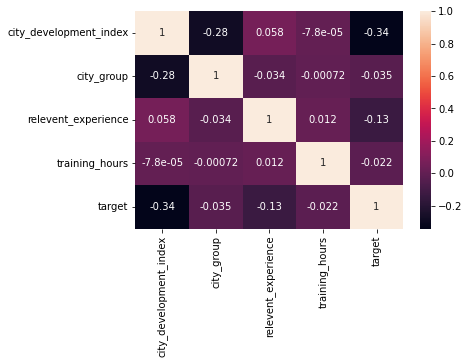

In [28]:
# Make a heatmap

plt.figure()
sns.heatmap(df_nonull[num_cols].corr(), annot=True);

City development index seems to have a fairly strong relationship with the target variable, as well as city group.

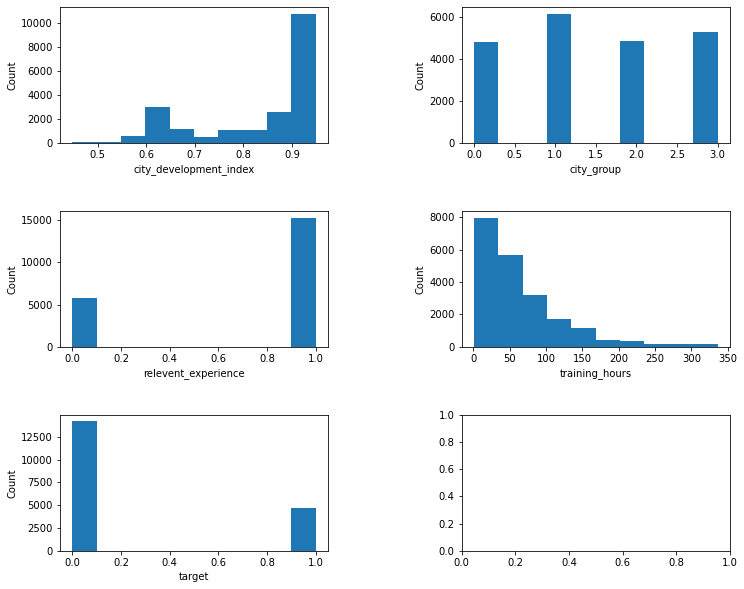

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(12,10))
fig.subplots_adjust(wspace=0.5, hspace=0.5)
for i, col in enumerate(num_cols):
    ax = axes.flatten()[i]
    ax.hist(x=col, data=df_nonull)
    ax.set(xlabel=col, ylabel='Count')

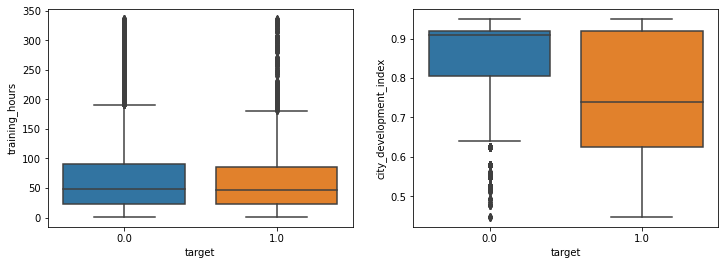

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(x='target', y='training_hours', data=df_nonull, ax=axes[0]);
sns.boxplot(x='target', y='city_development_index', data=df_nonull, ax=axes[1]);

There isn't much of a relationship between the target and training hours, but it seems that people from the highest CDIs are less likely to be interested in a job change.

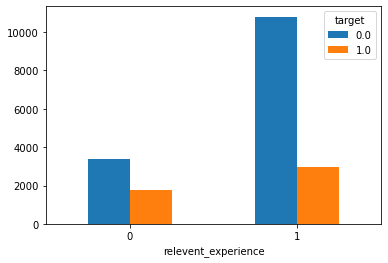

In [35]:
df_plot = df_nonull.groupby(['relevent_experience', 'target']).size().reset_index().pivot(
    columns='target', index='relevent_experience', values=0)
df_plot.plot(kind='bar', rot=0);

People without relevant experience seem more willing to be open to a job change than those with relevant experience.

## b) Categorical Columns

In [36]:
cat_cols = ['gender', 'city_group', 'education_level', 'exp_range', 'enrolled_university', 'major',
            'company_size', 'company_type', 'last_new_job']

In [37]:
# For reindexing cols

gender = ['Male', 'Female', 'Other', 'MISSING']
city = [0, 1, 2, 3]
ed_level = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd', 'MISSING']
exp_range = ['<=1','2-5','6-10','11-15','16-20','>20', 'MISSING']
enroll = ['no_enrollment', 'part_time', 'full_time', 'MISSING']
major = ['STEM', 'Humanities', 'Business Degree', 'Arts', 'No Major', 'Other', 'MISSING']
comp_sz = ['<10','10-49','50-99','100-499','500-999','1000-4999','5000-9999','10000+', 'MISSING']
comp_type = ['private_limited', 'public_sector', 'startup_funded', 'startup_earlystage', 'NGO', 'Other', 'MISSING']
last_job = ['never','1','2','3','4', '>4', 'MISSING']

cat_cols_idx = [gender, city, ed_level, exp_range, enroll, major, comp_sz, comp_type, last_job]

In [38]:
def cat_bar(cols, idx, y, df, figsize=(20,30)):
    """Plot bar graphs that: a) compare mean values of a target to different levels of a column
    b) compare different levels of a column to different levels of a target"""
    fig, axes = plt.subplots(len(cols),2, figsize=figsize)
    fig.subplots_adjust(wspace=0.3, hspace=0.5)
    
    for i, cols in enumerate(zip(cols,idx)):
        ax = axes.flatten()[i]
        plot1 = sns.barplot(x=cols[0], y=y, data=df_nonull, order=cols[1], ax=axes[i,0])
        plot1.set_xticklabels(plot1.get_xticklabels(), rotation=30)
                
        df_plot = df.groupby([cols[0], y]).size().reset_index().pivot(
            columns=y, index=cols[0], values=0).reindex(cols[1])
        df_plot.plot(kind='bar', rot=30, stacked=True, ax=axes[i,1])

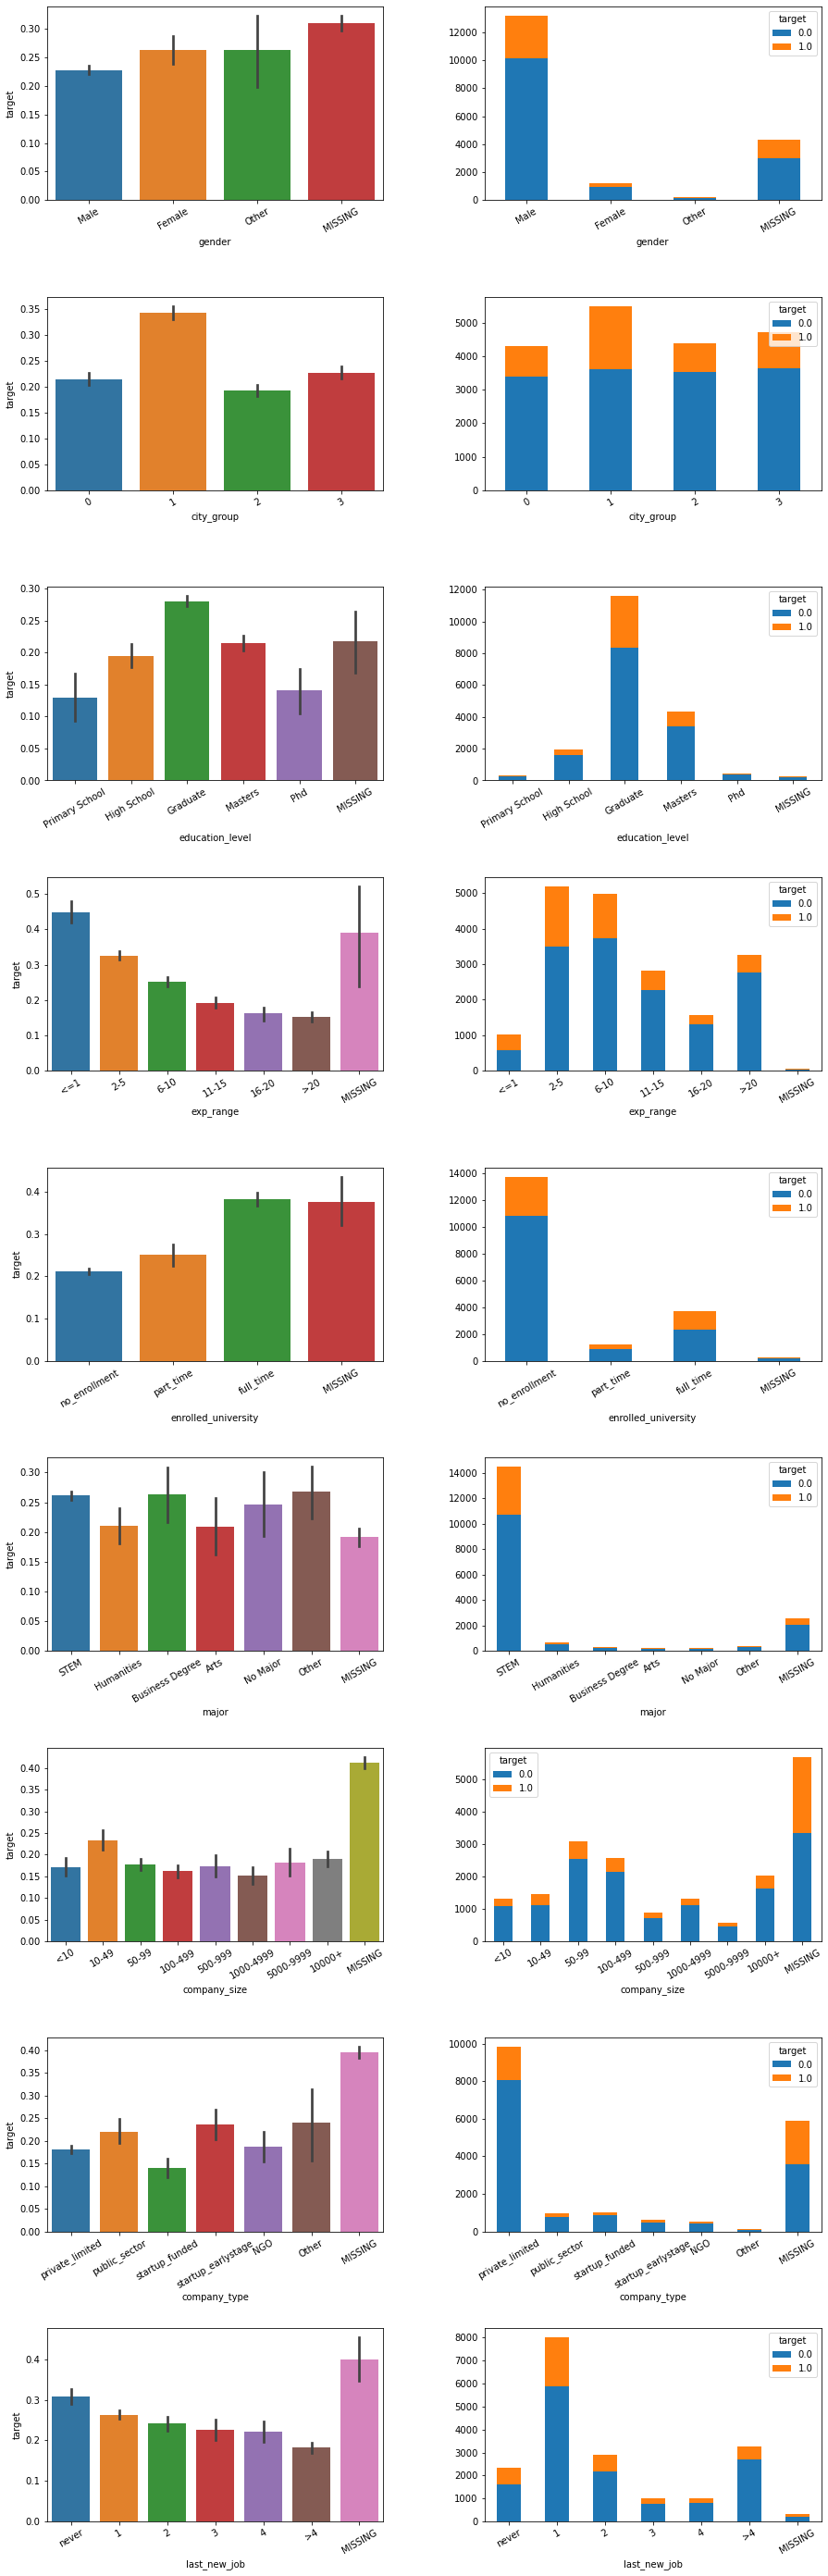

In [39]:
cat_bar(cat_cols, cat_cols_idx, 'target', df_nonull, figsize=(15,50))

#### Based on the above barplots, people are more likely to be open to a job change if...
- They identify as female or other.
- They are currently enrolled in university (current student).
- They are not a STEM student.
- They have less work experience.
- They work in the public sector, for an NGO, or (to some degree) a startup.

# III. Save New Dataset

In [40]:
# Save dfs with rows removed

df_null.to_csv('../data/df_clean_nulls2.csv')
df_nonull.to_csv('../data/df_clean_nonulls2.csv')